In [23]:
# --- Imports & setup
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA = Path(".")
CLEAN = DATA / "data_clean"
MODELDIR = DATA / "data_model"
MODELDIR.mkdir(exist_ok=True, parents=True)

In [13]:
# --- Load cleaned panel from wrangling step

panel = pd.read_csv(CLEAN / "eu_panel_clean.csv")

print("Panel shape:", panel.shape)
panel.head()

Panel shape: (271, 6)


,country,country_code,year,ewaste_recycling_rate_pct,population,gdp_current_usd
0,Austria,AUT,2010,79.9,8363404.0,3.898278e+11
1,Austria,AUT,2011,81.5,8391643.0,4.289547e+11
2,Austria,AUT,2012,80.0,8429991.0,4.067505e+11
3,Austria,AUT,2013,79.0,8479823.0,4.265805e+11
4,Austria,AUT,2014,79.6,8546356.0,4.385560e+11


In [14]:
# --- Basic profiling helper (optional, for sanity check)

def profile(df, name):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("columns:", df.columns.tolist())
    print(df.dtypes)
    print("\nMissing values per column:\n", df.isna().sum())

profile(panel, "EU panel (clean, from wrangling)")


=== EU panel (clean, from wrangling) ===
shape: (271, 6)
columns: ['country', 'country_code', 'year', 'ewaste_recycling_rate_pct', 'population', 'gdp_current_usd']
country                       object
country_code                  object
year                           int64
ewaste_recycling_rate_pct    float64
population                   float64
gdp_current_usd              float64
dtype: object

Missing values per column:
 country                      0
country_code                 0
year                         0
ewaste_recycling_rate_pct    0
population                   0
gdp_current_usd              0
dtype: int64


In [15]:
# --- Feature engineering for modeling

# 1) Create GDP per capita
panel["gdp_per_capita"] = panel["gdp_current_usd"] / panel["population"]

# 2) Log-transform GDP per capita to reduce skew
panel["log_gdp_per_capita"] = np.log(panel["gdp_per_capita"])

# 3) Drop rows where the target or key features are missing
model_df = panel.dropna(subset=[
    "ewaste_recycling_rate_pct",
    "population",
    "gdp_current_usd",
    "gdp_per_capita",
    "log_gdp_per_capita"
]).copy()

print("Modeling DF shape after dropping NAs:", model_df.shape)
model_df.head()


Modeling DF shape after dropping NAs: (271, 8)


,country,country_code,year,ewaste_recycling_rate_pct,population,gdp_current_usd,gdp_per_capita,log_gdp_per_capita
0,Austria,AUT,2010,79.9,8363404.0,3.898278e+11,46611.139342,10.749595
1,Austria,AUT,2011,81.5,8391643.0,4.289547e+11,51116.895352,10.841870
2,Austria,AUT,2012,80.0,8429991.0,4.067505e+11,48250.405914,10.784160
3,Austria,AUT,2013,79.0,8479823.0,4.265805e+11,50305.354577,10.825867
4,Austria,AUT,2014,79.6,8546356.0,4.385560e+11,51314.972262,10.845738


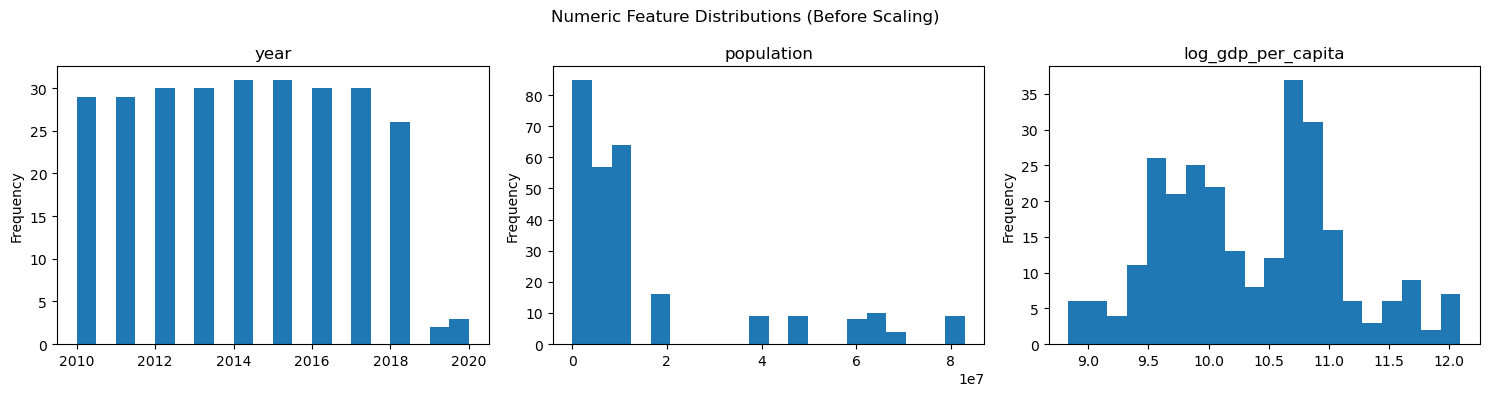

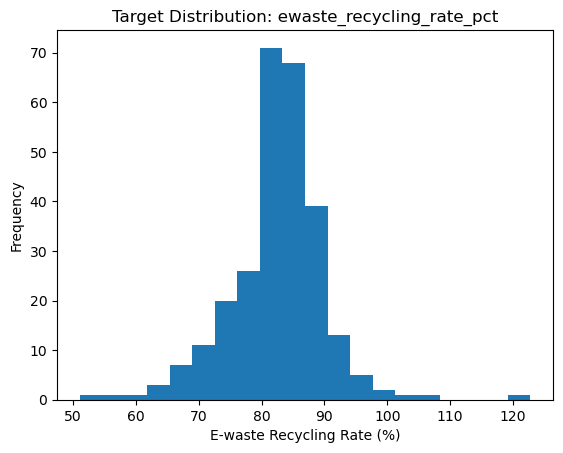

In [24]:
# --- Plot numeric feature distributions (before scaling)

numeric_features = ["year", "population", "log_gdp_per_capita"]

fig, axes = plt.subplots(1, len(numeric_features), figsize=(15, 4))

for ax, col in zip(axes, numeric_features):
    ax.hist(model_df[col].dropna(), bins=20)
    ax.set_title(col)
    ax.set_ylabel("Frequency")

plt.suptitle("Numeric Feature Distributions (Before Scaling)")
plt.tight_layout()
plt.show()

# Target distribution
plt.figure()
plt.hist(model_df["ewaste_recycling_rate_pct"].dropna(), bins=20)
plt.xlabel("E-waste Recycling Rate (%)")
plt.ylabel("Frequency")
plt.title("Target Distribution: ewaste_recycling_rate_pct")
plt.show()


In [16]:
# --- Define target and feature set

TARGET_COL = "ewaste_recycling_rate_pct"

# Numeric features: year, population, log GDP per capita
numeric_features = ["year", "population", "log_gdp_per_capita"]

# Categorical feature: country_code (one-hot encoded)
categorical_features = ["country_code"]

X = model_df[numeric_features + categorical_features]
y = model_df[TARGET_COL]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (271, 4)
y shape: (271,)


In [17]:
# --- Train / Validation / Test split (60 / 20 / 20)

# First: separate out test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_SEED
)

# Then: split remaining 80% into train (60%) and validation (20%)
# 0.25 of 0.80 = 0.20 overall, so this gives 60/20/20
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=RANDOM_SEED
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:  ", X_val.shape, y_val.shape)
print("Test shape: ", X_test.shape, y_test.shape)


Train shape: (162, 4) (162,)
Val shape:   (54, 4) (54,)
Test shape:  (55, 4) (55,)


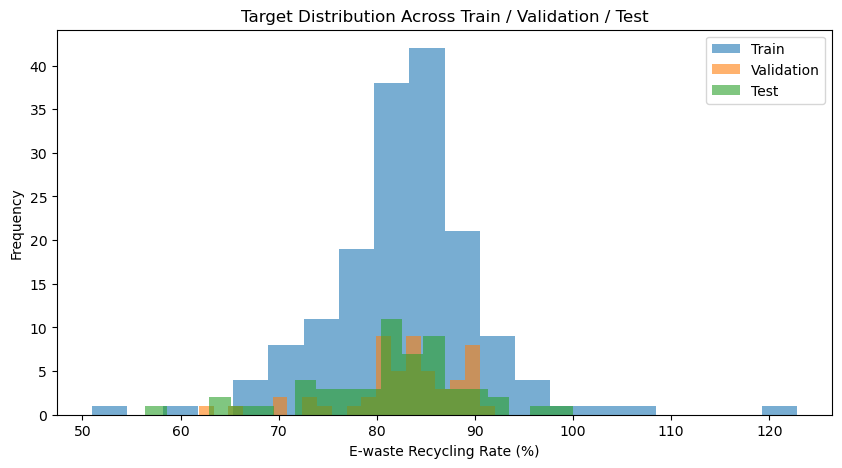

In [25]:
# --- Compare target distribution across train / val / test

plt.figure(figsize=(10, 5))

plt.hist(y_train, bins=20, alpha=0.6, label="Train")
plt.hist(y_val,   bins=20, alpha=0.6, label="Validation")
plt.hist(y_test,  bins=20, alpha=0.6, label="Test")

plt.xlabel("E-waste Recycling Rate (%)")
plt.ylabel("Frequency")
plt.title("Target Distribution Across Train / Validation / Test")
plt.legend()
plt.show()


In [18]:
# --- Preprocessing: dummy / indicator features + scaling

# Define transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(
    drop="first",          # avoid full dummy trap
    handle_unknown="ignore"
)

# ColumnTransformer applies:
# - StandardScaler to numeric columns
# - OneHotEncoder to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Wrap in a Pipeline so you can plug a model in later easily
# For now, this is just the preprocessing step
preprocess_only = Pipeline(steps=[
    ("preprocessor", preprocessor)
])

# Fit *only on the training data* to avoid data leakage
preprocess_only.fit(X_train)

print("Preprocessor fitted on training data.")


Preprocessor fitted on training data.


In [19]:
# --- Transform train / val / test sets

X_train_proc = preprocess_only.transform(X_train)
X_val_proc   = preprocess_only.transform(X_val)
X_test_proc  = preprocess_only.transform(X_test)

print("Transformed shapes:")
print("X_train_proc:", X_train_proc.shape)
print("X_val_proc:  ", X_val_proc.shape)
print("X_test_proc: ", X_test_proc.shape)


Transformed shapes:
X_train_proc: (162, 33)
X_val_proc:   (54, 33)
X_test_proc:  (55, 33)


In [26]:
# --- Sanity check: numeric columns after scaling (should be ~mean 0, std 1)

# Get numeric part of transformed train data
num_transformer = preprocess_only.named_steps["preprocessor"].named_transformers_["num"]
X_train_num = num_transformer.transform(X_train[numeric_features])

scaled_means = X_train_num.mean(axis=0)
scaled_stds = X_train_num.std(axis=0)

for col, m, s in zip(numeric_features, scaled_means, scaled_stds):
    print(f"{col}: mean={m:.3f}, std={s:.3f}")


year: mean=0.000, std=1.000
population: mean=0.000, std=1.000
log_gdp_per_capita: mean=-0.000, std=1.000


In [20]:
# --- Inspect the final feature space

# Get feature names from the ColumnTransformer so you know what each column is
# This works in recent versions of scikit-learn (>= 1.0)
ohe_feature_names = preprocess_only.named_steps["preprocessor"] \
    .named_transformers_["cat"] \
    .get_feature_names_out(categorical_features)

all_feature_names = (
    numeric_features
    + ohe_feature_names.tolist()
)

print("Number of engineered features:", len(all_feature_names))
print("First 20 features:", all_feature_names[:20])


Number of engineered features: 33
First 20 features: ['year', 'population', 'log_gdp_per_capita', 'country_code_BEL', 'country_code_BGR', 'country_code_CYP', 'country_code_CZE', 'country_code_DEU', 'country_code_DNK', 'country_code_ESP', 'country_code_EST', 'country_code_FIN', 'country_code_FRA', 'country_code_GBR', 'country_code_GRC', 'country_code_HRV', 'country_code_HUN', 'country_code_IRL', 'country_code_ISL', 'country_code_ITA']


In [21]:
# --- Save split data & preprocessor for the modeling notebook

import joblib

# Save the raw (untransformed) splits – useful for later experiments
X_train.to_csv(MODELDIR / "X_train_raw.csv", index=False)
X_val.to_csv(MODELDIR / "X_val_raw.csv", index=False)
X_test.to_csv(MODELDIR / "X_test_raw.csv", index=False)

y_train.to_csv(MODELDIR / "y_train.csv", index=False)
y_val.to_csv(MODELDIR / "y_val.csv", index=False)
y_test.to_csv(MODELDIR / "y_test.csv", index=False)

print("Saved raw splits to:", MODELDIR)

# Save the fitted preprocessing pipeline to reuse in the modeling step
joblib.dump(preprocess_only, MODELDIR / "preprocessor.pkl")

print("Saved fitted preprocessor →", MODELDIR / "preprocessor.pkl")


Saved raw splits to: data_model
Saved fitted preprocessor → data_model/preprocessor.pkl



- **Dummy / indicator features**  
  - `country_code` is treated as a categorical variable.  
  - One-hot encoding is applied via `OneHotEncoder(handle_unknown="ignore", drop="first")` inside a `ColumnTransformer`.

- **Scale standardization**  
  - Numeric features (`year`, `population`, `log_gdp_per_capita`) are standardized using `StandardScaler`, which subtracts the mean and divides by the standard deviation, fitted on the **training set only**.

- **Train / validation / test split**  
  - The cleaned modeling dataset (`model_df`) is split into:
    - 60% training, 20% validation, 20% test  
  - Splits are created using `train_test_split` with `random_state=42` for reproducibility.

- **Model-training development dataset**  
  - The raw splits and a fitted preprocessing pipeline are saved in `data_model/`.  
  - The next notebook can simply load `preprocessor.pkl`, attach a model (e.g., LinearRegression, RandomForestRegressor), and fit on `(X_train, y_train)` using the same transformations.
